<a href="https://colab.research.google.com/github/alexey9019/data/blob/master/sem_15_ds3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Приблизительный набор действий при работе с данными


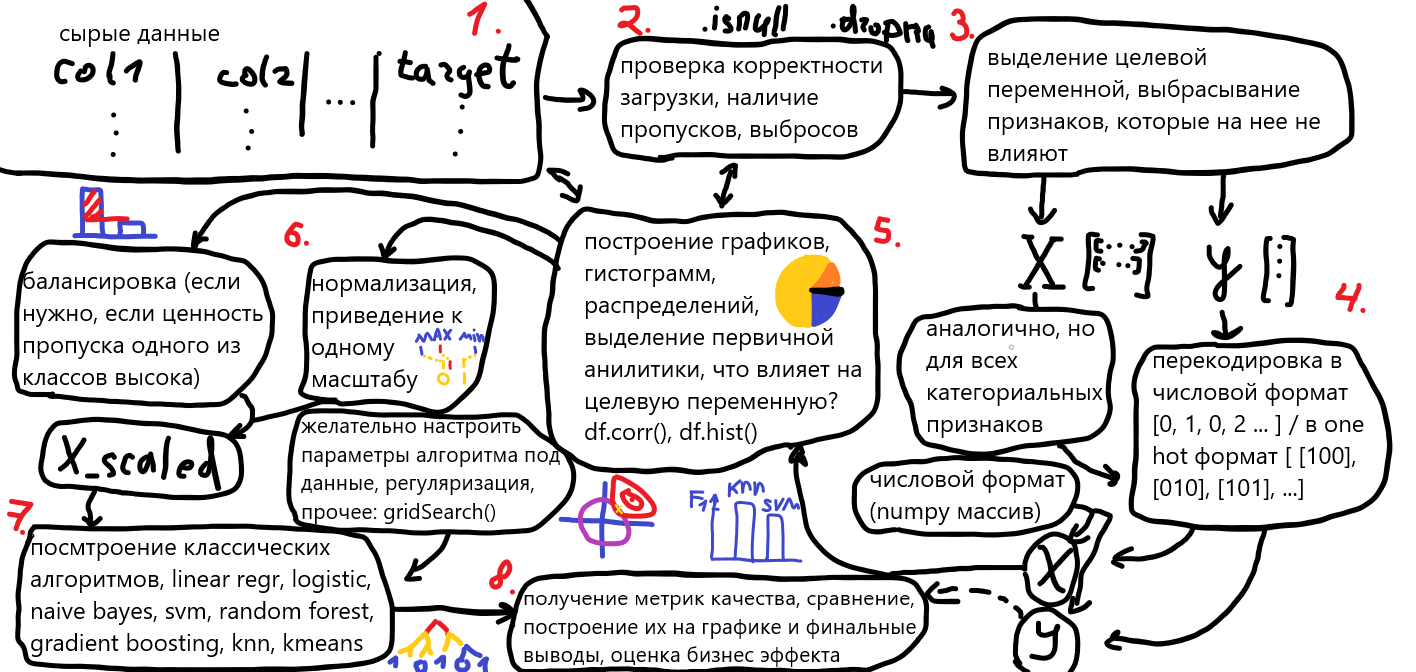

# Загрузка данных

На основе https://www.kaggle.com/zynicide/wine-reviews#winemag-data_first150k.csv

In [0]:
# импортируем зависимости
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install chart_studio
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [0]:
!git clone https://github.com/tixonsit/Sberbank_materials.git

Cloning into 'Sberbank_materials'...
remote: Enumerating objects: 45, done.
remote: Total 45 (delta 0), reused 0 (delta 0), pack-reused 45
Unpacking objects: 100% (45/45), done.
Checking out files: 100% (20/20), done.


In [0]:
df = pd.read_csv('/content/Sberbank_materials/winemag-data-130k-v2.csv', index_col='Unnamed: 0')
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Корректно ли все загрузилось, сколько пропусков?

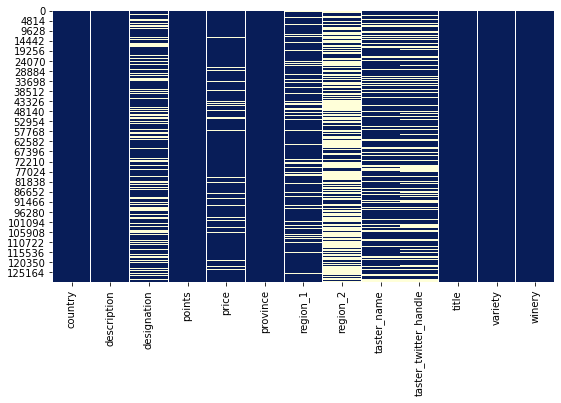

In [0]:
fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(df.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

Нам важно, чтоб был столбец цены. Столбцы region_2 (2й регион), taster_name (имя тестировщика), taster_twitter_handle (твиттер тестировщика), designation (назначение) нам не особо важны. Остальные стобцы почистим

In [0]:
df.drop(columns=['region_2', 'taster_name', 'taster_twitter_handle', 'designation'], inplace=True)
df.dropna(inplace=True)
df.head()

,country,description,points,price,province,region_1,title,variety,winery
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Navarra,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",87,16.0,Sicily & Sardinia,Vittoria,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo


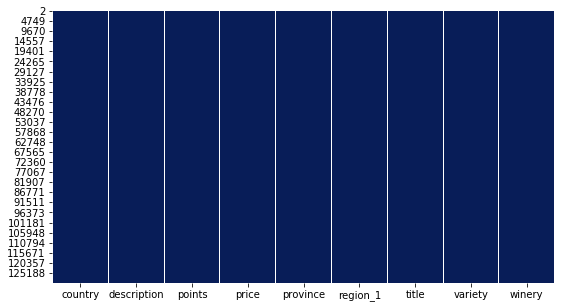

In [0]:
fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(df.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

In [0]:
len(df)

101400

# Графическое исследование данных

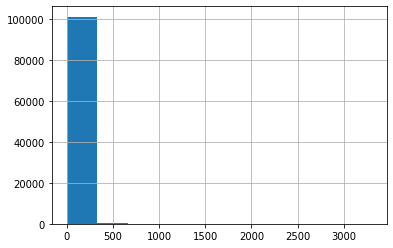

In [0]:
df['price'].hist()

Давайте отфильтруем очень дорогие и посмотрим на обычный ценовой диапазон

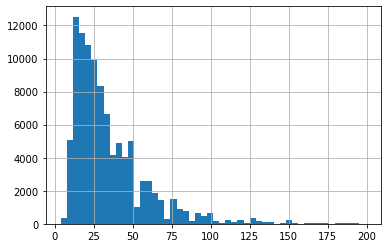

In [0]:
df[df['price'] < 200]['price'].hist(bins = 50)

In [0]:
# посмотрим на основную информацию
df['price'].describe()

count    101400.000000
mean         36.936558
std          41.895979
min           4.000000
25%          18.000000
50%          28.000000
75%          45.000000
max        3300.000000
Name: price, dtype: float64

Медиана ~28 за бутылку, средняя ~37, стандартное отклонение ~42 (в $)

А что по оценкам?

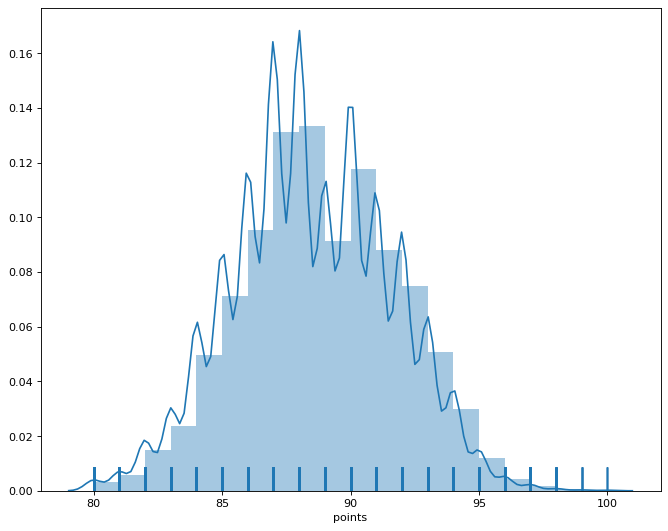

In [0]:
# import pylab as pl
# pl.suptitle("Распределение по оценкам")
# df['points'].hist(bins=20)
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
sns.distplot(df['points'], bins=20, rug=True)

Нормально распределены.

In [0]:
df['points'].describe()

count    101400.000000
mean         88.463343
std           3.060467
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

Средняя 88, медиана 88.

# Работа с признаками

Хорошо, теперь имеем датасет из 101400 вин и их оценок. У нас много столбцов с описанием (в виде текста, давайте их предобарботаем - приведем к нижнему регистру, уберем пунктуацию.

Т.к. текста много - надо оценить сколько уникальных слов есть в описании

In [0]:
import string

def preprocess(doc):
    # к нижнему регистру
    doc = doc.lower()
    # убираем пунктуацию, пробелы, прочее
    for p in string.punctuation + string.whitespace:
        doc = doc.replace(p, ' ')
    # убираем лишние пробелы, объединяем обратно
    doc = doc.strip()
    doc = ' '.join([w for w in doc.split(' ') if w != ''])
    return doc

In [0]:
# найдем все стобцы с типом данных строки
df.select_dtypes(include= np.object)

,country,description,province,region_1,title,variety,winery
2,US,"Tart and snappy, the flavors of lime flesh and...",Oregon,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,Northern Spain,Navarra,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",Sicily & Sardinia,Vittoria,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
...,...,...,...,...,...,...,...
129965,France,"While it's rich, this beautiful dry wine also ...",Alsace,Alsace,Domaine Rieflé-Landmann 2013 Seppi Landmann Va...,Pinot Gris,Domaine Rieflé-Landmann
129967,US,Citation is given as much as a decade of bottl...,Oregon,Oregon,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation
129968,France,Well-drained gravel soil gives this wine its c...,Alsace,Alsace,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser
129969,France,"A dry style of Pinot Gris, this is crisp with ...",Alsace,Alsace,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss


In [0]:
#  применим к этим столбцам нашу функцию понижения текста
for colname in df.select_dtypes(include= np.object).columns:
    df[colname] = df[colname].map(preprocess)
df.head()

,country,description,points,price,province,region_1,title,variety,winery
2,us,tart and snappy the flavors of lime flesh and ...,87,14.0,oregon,willamette valley,rainstorm 2013 pinot gris willamette valley,pinot gris,rainstorm
3,us,pineapple rind lemon pith and orange blossom s...,87,13.0,michigan,lake michigan shore,st julian 2013 reserve late harvest riesling l...,riesling,st julian
4,us,much like the regular bottling from 2012 this ...,87,65.0,oregon,willamette valley,sweet cheeks 2012 vintner s reserve wild child...,pinot noir,sweet cheeks
5,spain,blackberry and raspberry aromas show a typical...,87,15.0,northern spain,navarra,tandem 2011 ars in vitro tempranillo merlot na...,tempranillo merlot,tandem
6,italy,here s a bright informal red that opens with a...,87,16.0,sicily sardinia,vittoria,terre di giurfo 2013 belsito frappato vittoria,frappato,terre di giurfo


Что можно сделать с текстом? Преобразовать его в матрицу tfidf, которая каждому слову в тексте выставит его меру tfidf:

Каждому тексту (набору слов) ставит в соответсвие вектор (набор цифр, по одной для каждого слова): text -> vector $v$ from $R^N$ where $N$ is a vocabulary size.

$TF-IDF(token, document) = TF(token, document) * IDF(token, document)$

$TF$ Частотность термина - кол-во встречаний в выбранном документе (в нашем случае описании):

$TF(token, document) = \frac{n_{token}}{\sum_{k}n_k}.$

$IDF$ обратная частота - логарифм от (количества документов) / (кол-во документов, где появлялось слово)

$IDF(token, all\_documents) = \frac{Total\ number\ of\ documents}{number\ of\ documents\ where\ token\ appeared}.$

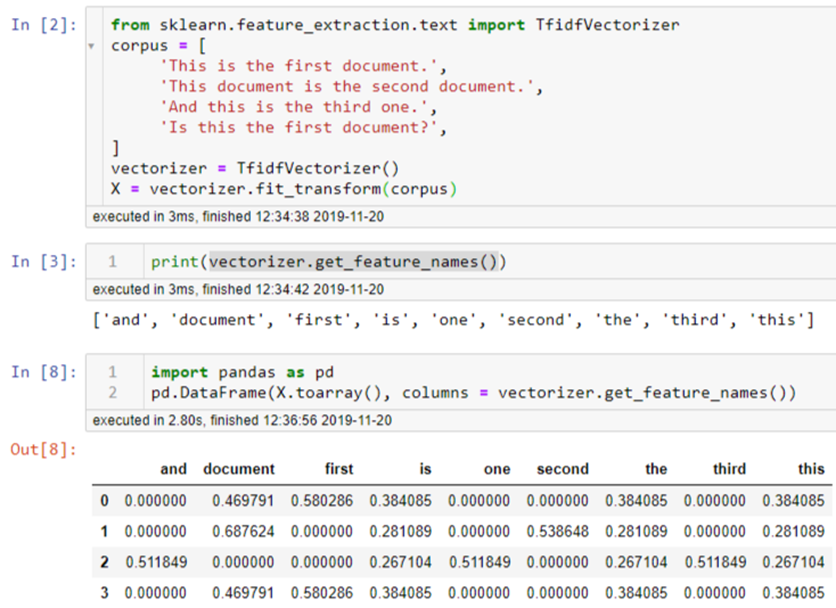

In [0]:
df = df[:50000]

In [0]:
# импортируем tfidf преобразование
from sklearn.feature_extraction.text import TfidfVectorizer

# инициализировали алгоритм
vectorizer = TfidfVectorizer()
# преобразовали его в матрицу tfidf как в примере на картинке выше
X_np = vectorizer.fit_transform(df['description'].values)
# отобразили его размерность
print(X_np.shape)

(50000, 21545)


Скорее всего colab на этом месте напишет crashed - run out of memory и предложит (слева внизу) переключиться на runtime с большим кол-вом оперативной памяти (25 гигов)

In [0]:
# т.к. сам тип матрицы из scipy - преобразуем в tfidf
X_np = X_np.toarray()

Мы получили преобразованные описания в виде набор из 27580 столбцов, которые отвечают уникальным словам в этом описании. Сами слова можно найти через vectorizer.get_feature_names()

In [0]:
# отобразим произвольные слова
print(vectorizer.get_feature_names()[13000:13010])

['jellybean', 'jenke', 'jenkins', 'jenne', 'jenner', 'jennifer', 'jensen', 'jeremy', 'jeriko', 'jerked']



----

# Для начала решим задачу задачу без текстовых описаний

## Кластеризация

Давайте для начала будем решать задачу кластеризации. Разделим наши оценки вина от 1 до 5, где 5 - максимальная, 1 - минимальная (исходя из колонки points)

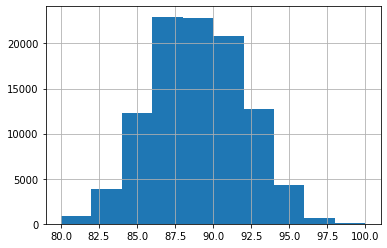

In [0]:
df['points'].hist()

С учетом этого распределения оценки будут следующие
* 1: 80-84 - очень плохое вино
* 2: 84-88 - плохое вино
* 3: 88-92 - среднестатистическое вино
* 4: 92-96 - хорошее вино
* 5: 96-100 - очень хорошее

In [0]:
def make_class(point):
    if point < 84:
        return 1
    elif point >= 84 and point < 88:
        return 2
    elif point >= 88 and point < 92:
        return 3
    elif point >= 92 and point < 96:
        return 4
    elif point >= 96:
        return 5

df['points'] = df['points'].apply(make_class)
df.head(10)

,country,description,points,price,province,region_1,title,variety,winery
2,us,tart and snappy the flavors of lime flesh and ...,2,14.0,oregon,willamette valley,rainstorm 2013 pinot gris willamette valley,pinot gris,rainstorm
3,us,pineapple rind lemon pith and orange blossom s...,2,13.0,michigan,lake michigan shore,st julian 2013 reserve late harvest riesling l...,riesling,st julian
4,us,much like the regular bottling from 2012 this ...,2,65.0,oregon,willamette valley,sweet cheeks 2012 vintner s reserve wild child...,pinot noir,sweet cheeks
5,spain,blackberry and raspberry aromas show a typical...,2,15.0,northern spain,navarra,tandem 2011 ars in vitro tempranillo merlot na...,tempranillo merlot,tandem
6,italy,here s a bright informal red that opens with a...,2,16.0,sicily sardinia,vittoria,terre di giurfo 2013 belsito frappato vittoria,frappato,terre di giurfo
7,france,this dry and restrained wine offers spice in p...,2,24.0,alsace,alsace,trimbach 2012 gewurztraminer alsace,gewürztraminer,trimbach
9,france,this has great depth of flavor with its fresh ...,2,27.0,alsace,alsace,jean baptiste adam 2012 les natures pinot gris...,pinot gris,jean baptiste adam
10,us,soft supple plum envelopes an oaky structure i...,2,19.0,california,napa valley,kirkland signature 2011 mountain cuvée caberne...,cabernet sauvignon,kirkland signature
11,france,this is a dry wine very spicy with a tight tau...,2,30.0,alsace,alsace,leon beyer 2012 gewurztraminer alsace,gewürztraminer,leon beyer
12,us,slightly reduced this wine offers a chalky tan...,2,34.0,california,alexander valley,louis m martini 2012 cabernet sauvignon alexan...,cabernet sauvignon,louis m martini


In [0]:
df['points'].value_counts()

3    43671
2    35212
4    17002
1     4803
5      712
Name: points, dtype: int64

Классы сильно разбалансированы, но нам важно будет отличить хорошее вино от среднего и ниже плохого, так что "очень плохие" и "очень хорошие" нас волнуют меньше (составляют меньше 5 процентов от всего количества)

In [0]:
(4803+712)/(43671+35212+17002+4803+712)

0.05438856015779093

### Подготовка данных, нормализация

Подключим нашу старую функцию кодировки данных

In [0]:
# Подключаем класс для предобработки данных
from sklearn import preprocessing

# Напишем функцию, которая принимает на вход DataFrame, кодирует числовыми значениями категориальные признаки
# и возвращает обновленный DataFrame и сами кодировщики.
def number_encode_features(init_df):
    result = init_df.copy() # копируем нашу исходную таблицу
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object: # np.object -- строковый тип / если тип столбца - строка, то нужно его закодировать
            encoders[column] = preprocessing.LabelEncoder() # для колонки column создаем кодировщик
            result[column] = encoders[column].fit_transform(result[column]) # применяем кодировщик к столбцу и перезаписываем столбец
    return result, encoders

# используем все, кроме описания
encoded_data, encoders = number_encode_features(df.drop(columns='description')) # Теперь encoded data содержит закодированные кат. признаки 
encoded_data.head()

,country,points,price,province,region_1,title,variety,winery
2,6,2,14.0,43,1192,69968,319,10714
3,6,2,13.0,30,538,78601,347,11833
4,6,2,65.0,43,1192,80139,323,12012
5,5,2,15.0,39,739,80785,430,12075
6,4,2,16.0,50,1179,82412,131,12334


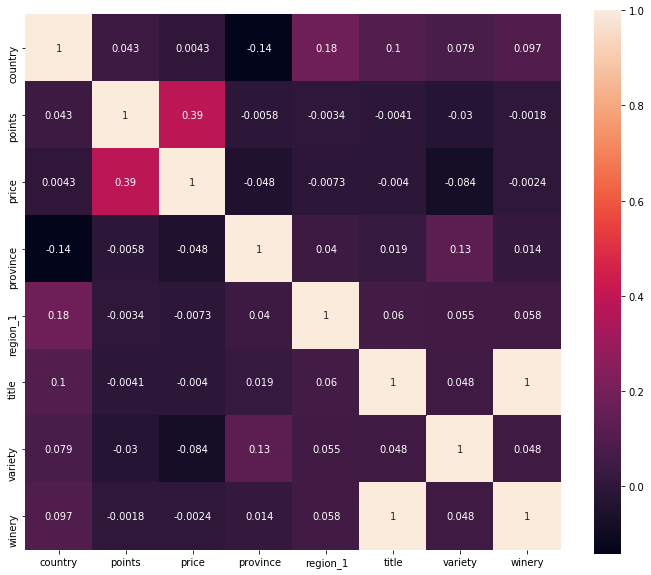

In [0]:
plt.subplots(figsize=(12, 10))
sns.heatmap(encoded_data.corr(), square = True, annot=True)
plt.show()

Отсюда можно понять, что title и winery просто совпадают, дропаем

In [0]:
encoded_data.drop(columns=['winery'], inplace=True)
encoded_data.head()

,country,points,price,province,region_1,title,variety
2,6,2,14.0,43,1192,69968,319
3,6,2,13.0,30,538,78601,347
4,6,2,65.0,43,1192,80139,323
5,5,2,15.0,39,739,80785,430
6,4,2,16.0,50,1179,82412,131


In [0]:
# выделим целевую переменную - качество
y = np.array(encoded_data['points'])

In [0]:
y

array([2, 2, 2, ..., 3, 3, 3])

In [0]:
X = np.array(encoded_data.drop(columns=['points']), float)
X

array([[6.0000e+00, 1.4000e+01, 4.3000e+01, 1.1920e+03, 6.9968e+04,
        3.1900e+02],
       [6.0000e+00, 1.3000e+01, 3.0000e+01, 5.3800e+02, 7.8601e+04,
        3.4700e+02],
       [6.0000e+00, 6.5000e+01, 4.3000e+01, 1.1920e+03, 8.0139e+04,
        3.2300e+02],
       ...,
       [3.0000e+00, 3.0000e+01, 0.0000e+00, 2.1000e+01, 2.9632e+04,
        1.4900e+02],
       [3.0000e+00, 3.2000e+01, 0.0000e+00, 2.1000e+01, 3.0149e+04,
        3.1900e+02],
       [3.0000e+00, 2.1000e+01, 0.0000e+00, 2.1000e+01, 3.0676e+04,
        1.4900e+02]])

In [0]:
# нормализуем наши данные
from sklearn.preprocessing import scale
# скейлим (первой формулой выше) 
# тут получаем результаты на НЕ one hot кодировании, как делали на 6 занятии (другой тип перекодировки категор. признаков)
X_scaled = scale(X, with_std=True, with_mean=True)
X_scaled

array([[ 0.78009753, -0.54746712,  0.72834998,  1.58867093,  0.88890943,
         0.45110662],
       [ 0.78009753, -0.57133588,  0.1297823 , -0.18228409,  1.21205359,
         0.64236518],
       [ 0.78009753,  0.66983946,  0.72834998,  1.58867093,  1.26962288,
         0.47842927],
       ...,
       [-1.07152401, -0.16556702, -1.25152774, -1.58225923, -0.62091829,
        -0.71010609],
       [-1.07152401, -0.11782951, -1.25152774, -1.58225923, -0.60156632,
         0.45110662],
       [-1.07152401, -0.38038583, -1.25152774, -1.58225923, -0.58184004,
        -0.71010609]])

### Алгоритмы

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

### KNN

In [0]:
# Будем использовать модель k ближайших соседей, которую проходили на 5 занятии

# Инициализируем алгоритм
knn = KNeighborsClassifier()

# В sklearn есть специальный модуль для работы с кросс-валидацией
from sklearn.model_selection import GridSearchCV

# Зададим сетку - среди каких значений выбирать наилучший параметр.
knn_grid = {'n_neighbors': np.array(np.linspace(1, 100, 10), dtype='int')} # перебираем по параметру <<n_neighbors>>, по сетке заданной np.linspace(2, 100, 10)

# Создаем объект кросс-валидации
gs = GridSearchCV(knn, knn_grid, cv=5)

# Обучаем его на 10к значениях, для простоты
gs.fit(X_scaled[:10000], y[:10000])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([  1,  12,  23,  34,  45,  56,  67,  78,  89, 100])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
# Функция отрисовки графиков
def grid_plot(x, y, x_label, title, y_label='cross_val, accuracy'):
    # определили размер графика
    plt.figure(figsize=(12, 6))
    # добавили сетку на фон
    plt.grid(True)
    # построили по х - число соседей, по y - точность
    plt.plot(x, y, 'go-')
    # добавили подписи осей и название графика
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

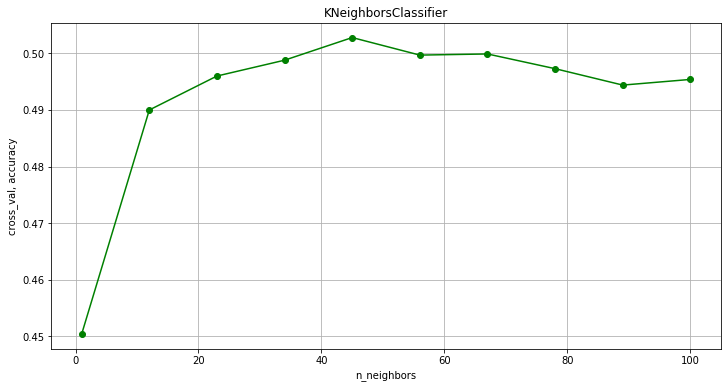

In [0]:
# Строим график зависимости качества от числа соседей
# замечание: результаты обучения хранятся в атрибуте cv_results_ объекта gs
grid_plot(knn_grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

In [0]:
gs.best_params_, gs.best_score_

({'n_neighbors': 45}, 0.5028)

У нас 5 классов, мин точность - 0,3. Будем повышать

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

In [0]:
knn = KNeighborsClassifier(n_neighbors=45, n_jobs=2)

knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=2, n_neighbors=45, p=2,
                     weights='uniform')

In [0]:
preds = knn.predict(X_test)

In [0]:
from sklearn import metrics

print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.22      0.01      0.01       973
           2       0.56      0.58      0.57      6913
           3       0.54      0.66      0.59      8793
           4       0.56      0.40      0.47      3463
           5       0.64      0.05      0.09       138

    accuracy                           0.55     20280
   macro avg       0.50      0.34      0.35     20280
weighted avg       0.54      0.55      0.53     20280



### Random forest

In [0]:
# перебираем глубину
# перебираем мин кол-во для разделения
# максимально кол-во признаков для более случайной выборки
param_grid = {'max_depth': [i for i in range(2, 15)],
              'min_samples_split': [i for i in range(2, 10)],
              'max_features': [2, len(X_scaled[0])-1]
              }

# инициализируем случайный лес с перебором по кросс-вал на выбранных выше праметрах
gs = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
gs.fit(X_scaled[:15000], y[:15000])

# best_params_ содержит в себе лучшие подобранные параметры, best_score_ лучшее качество
print()
gs.best_params_, gs.best_score_

({'max_depth': 6, 'max_features': 5, 'min_samples_split': 4}, 0.5518)

In [0]:
# gs.cv_results_

In [0]:
def plot_feature_importances(model, columns):
    # выбираем кол-во признаков для отображения
    nr_f = 10
    # берем данные для графика
    # берем алгоритм с лучшими параметрами
    # по х мы берем важность признаков исходя из критерия Джини, сортируем их вместе с названиями колонок по возрастанию
    imp = pd.Series(data = model.best_estimator_.feature_importances_, 
                    index=columns).sort_values(ascending=False)
    # построили фигуру
    plt.figure(figsize=(7,5))
    # отобразили название
    plt.title("Важность признаков | Feature importance")
    # построили 10 самых важных признаков
    ax = sns.barplot(y=imp.index[:nr_f], x=imp.values[:nr_f], orient='h')

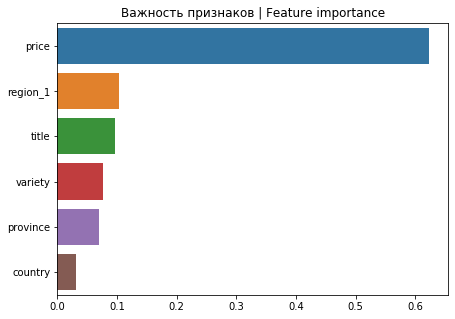

In [0]:
# вызвали функцию отображения самых важных признаков
plot_feature_importances(gs, list(encoded_data.drop(columns=['points']).columns))

In [0]:
# инициализируем и проверим на лучших параметрах
forest = RandomForestClassifier(max_depth=9,
                                min_samples_split=2,
                                max_features=4)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
preds = forest.predict(X_test)

print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.57      0.01      0.02       973
           2       0.60      0.56      0.58      6913
           3       0.55      0.69      0.61      8793
           4       0.56      0.44      0.49      3463
           5       0.50      0.05      0.09       138

    accuracy                           0.57     20280
   macro avg       0.56      0.35      0.36     20280
weighted avg       0.57      0.57      0.55     20280



Уже значительно лучше КNN, а если алгоритм взять продвинутее?

### Градиентный бустинг на деревьях

In [0]:
# перебираем глубину
# перебираем мин кол-во для разделения
# перебираем кол-во деревьев

param_grid = {'n_estimators': [i for i in range(50, 400, 50)],
              'max_depth': [i for i in range(2, 15, 3)],
              'max_features': [i for i in range(2, len(X_scaled[0])-1, 3)]
              }

# инициализируем случайный лес с перебором по кросс-вал на выбранных выше праметрах
gs = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=3)
gs.fit(X_scaled[:15000], y[:15000])

# best_params_ содержит в себе лучшие подобранные параметры, best_score_ лучшее качество
print()
gs.best_params_, gs.best_score_

KeyboardInterrupt: ignored

In [0]:
# grad_b = GradientBoostingClassifier(n_estimators= 
#                                     max_depth=
#                                     max_features=
#                                     )

# нужно долго ждать, в переборе параметров

In [0]:
# по этой причине используем стандартный
grad_b = GradientBoostingClassifier(n_estimators=400)

In [0]:
grad_b.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=400,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [0]:
from sklearn import metrics

print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.57      0.01      0.02       973
           2       0.60      0.56      0.58      6913
           3       0.55      0.69      0.61      8793
           4       0.56      0.44      0.49      3463
           5       0.50      0.05      0.09       138

    accuracy                           0.57     20280
   macro avg       0.56      0.35      0.36     20280
weighted avg       0.57      0.57      0.55     20280



## Регрессия

### Подготовка данных, нормализация

In [0]:
# вернем нашу изначальный датасет и перекодируем
df = pd.read_csv('/content/Sberbank_materials/winemag-data-130k-v2.csv', index_col='Unnamed: 0')
df.drop(columns=['region_2', 'taster_name', 'taster_twitter_handle', 'designation'], inplace=True)
df.dropna(inplace=True)

In [0]:
encoded_data, encoders = number_encode_features(df.drop(columns='description')) # Теперь encoded data содержит закодированные кат. признаки 

encoded_data.head()

,country,points,price,province,region_1,title,variety,winery
2,6,87,14.0,43,1192,69940,318,10741
3,6,87,13.0,30,538,78569,347,11860
4,6,87,65.0,43,1192,80105,322,12038
5,5,87,15.0,39,739,80765,430,12107
6,4,87,16.0,50,1179,82494,131,12369


In [0]:
# выделим целевую переменную - качество
y = np.array(encoded_data['points'])
X = np.array(encoded_data.drop(columns=['points']), float)

In [0]:
# нормализуем наши данные
from sklearn.preprocessing import scale
# скейлим (первой формулой выше) 
# тут получаем результаты на НЕ one hot кодировании, как делали на 6 занятии (другой тип перекодировки категор. признаков)
X_scaled = scale(X, with_std=True, with_mean=True)
X_scaled

array([[ 0.78009753, -0.54746712,  0.72834998, ...,  0.88738914,
         0.44566919,  0.88655129],
       [ 0.78009753, -0.57133588,  0.1297823 , ...,  1.21030704,
         0.64369138,  1.16703452],
       [ 0.78009753,  0.66983946,  0.72834998, ...,  1.26778785,
         0.47298259,  1.21165116],
       ...,
       [-1.07152401, -0.16556702, -1.25152774, ..., -0.65171936,
        -0.70832219, -0.5431863 ],
       [-1.07152401, -0.11782951, -1.25152774, ..., -0.63472959,
         0.44566919, -0.52188061],
       [-1.07152401, -0.38038583, -1.25152774, ..., -0.61500799,
        -0.70832219, -0.49531115]])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

### Random forest

In [0]:
from sklearn.ensemble import RandomForestRegressor

# перебираем глубину
# перебираем мин кол-во для разделения
# максимально кол-во признаков для более случайной выборки
param_grid = {'max_depth': [i for i in range(2, 15)],
              'min_samples_split': [i for i in range(2, 10)],
              'max_features': [2, len(X_scaled[0])-1]
              }

# инициализируем случайный лес с перебором по кросс-вал на выбранных выше праметрах
gs = GridSearchCV(RandomForestRegressor(), param_grid, cv=3)
gs.fit(X_scaled[:15000], y[:15000])

# best_params_ содержит в себе лучшие подобранные параметры, best_score_ лучшее качество
print()
gs.best_params_, gs.best_score_

({'max_depth': 13, 'max_features': 2, 'min_samples_split': 9},
 0.39987390489760083)

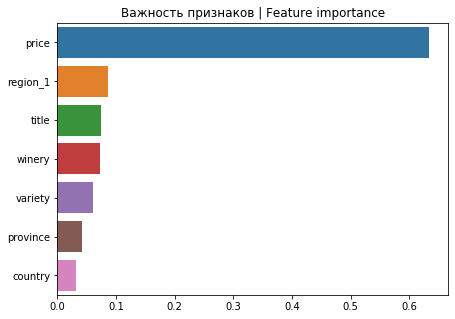

In [0]:
# вызвали функцию отображения самых важных признаков
plot_feature_importances(gs, list(encoded_data.drop(columns=['points']).columns))

In [0]:
# настроили наилучший алгоритм, попробуем оценить его по R^2 на test

In [0]:
from sklearn.ensemble import RandomForestRegressor
# инициализируем и проверим на лучших параметрах
forest = RandomForestRegressor(max_depth=13,
                               max_features=2,
                               min_samples_split=9)
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
                      max_features=2, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=9,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [0]:
from sklearn.metrics import r2_score

In [0]:
preds = forest.predict(X_test)

r2_score(y_test, preds)

0.446786073725016

(array([1.000e+00, 0.000e+00, 4.000e+00, 9.000e+00, 5.000e+00, 1.200e+01,
        1.300e+01, 1.700e+01, 2.900e+01, 3.900e+01, 3.600e+01, 7.000e+01,
        9.700e+01, 1.130e+02, 1.300e+02, 1.760e+02, 1.980e+02, 2.730e+02,
        3.560e+02, 4.400e+02, 5.230e+02, 5.350e+02, 7.360e+02, 8.560e+02,
        8.780e+02, 1.136e+03, 1.119e+03, 1.297e+03, 1.369e+03, 1.271e+03,
        1.218e+03, 1.232e+03, 1.091e+03, 9.690e+02, 9.110e+02, 7.650e+02,
        6.910e+02, 5.010e+02, 3.760e+02, 2.800e+02, 1.800e+02, 1.110e+02,
        8.500e+01, 6.300e+01, 3.500e+01, 1.900e+01, 6.000e+00, 4.000e+00,
        2.000e+00, 3.000e+00]),
 array([-10.04809837,  -9.69470724,  -9.3413161 ,  -8.98792497,
         -8.63453383,  -8.28114269,  -7.92775156,  -7.57436042,
         -7.22096928,  -6.86757815,  -6.51418701,  -6.16079587,
         -5.80740474,  -5.4540136 ,  -5.10062247,  -4.74723133,
         -4.39384019,  -4.04044906,  -3.68705792,  -3.33366678,
         -2.98027565,  -2.62688451,  -2.27349337,  -1.92

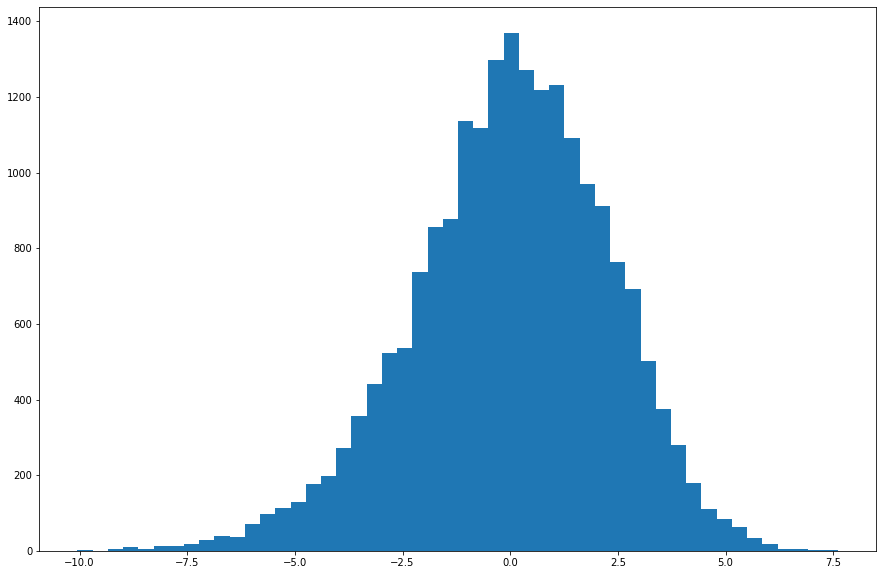

In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import gcf
fig = gcf()

fig.set_size_inches(15, 10, forward=True)

plt.hist(y_test - preds, bins = 50)

### Градиентный бустинг на деревьях

In [0]:
from sklearn.ensemble import GradientBoostingRegressor

boost_regr = GradientBoostingRegressor(n_estimators=400, max_depth = 13, max_features = 2, min_samples_split = 9)
boost_regr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=13,
                          max_features=2, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=9,
                          min_weight_fraction_leaf=0.0, n_estimators=400,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
preds = boost_regr.predict(X_test)

r2_score(y_test, preds)

0.5318620792408957

(array([1.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 8.000e+00, 4.000e+00,
        5.000e+00, 1.200e+01, 2.000e+01, 3.300e+01, 3.900e+01, 3.600e+01,
        5.600e+01, 8.300e+01, 1.040e+02, 1.410e+02, 1.830e+02, 2.880e+02,
        3.100e+02, 3.720e+02, 4.860e+02, 6.210e+02, 7.630e+02, 8.920e+02,
        1.130e+03, 1.384e+03, 1.653e+03, 1.763e+03, 1.734e+03, 1.516e+03,
        1.340e+03, 1.183e+03, 9.410e+02, 8.370e+02, 6.130e+02, 5.110e+02,
        3.770e+02, 2.700e+02, 1.970e+02, 1.410e+02, 7.500e+01, 7.300e+01,
        3.200e+01, 2.300e+01, 1.400e+01, 5.000e+00, 3.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00]),
 array([-10.50573885, -10.12649286,  -9.74724687,  -9.36800087,
         -8.98875488,  -8.60950888,  -8.23026289,  -7.8510169 ,
         -7.4717709 ,  -7.09252491,  -6.71327892,  -6.33403292,
         -5.95478693,  -5.57554093,  -5.19629494,  -4.81704895,
         -4.43780295,  -4.05855696,  -3.67931096,  -3.30006497,
         -2.92081898,  -2.54157298,  -2.16232699,  -1.78

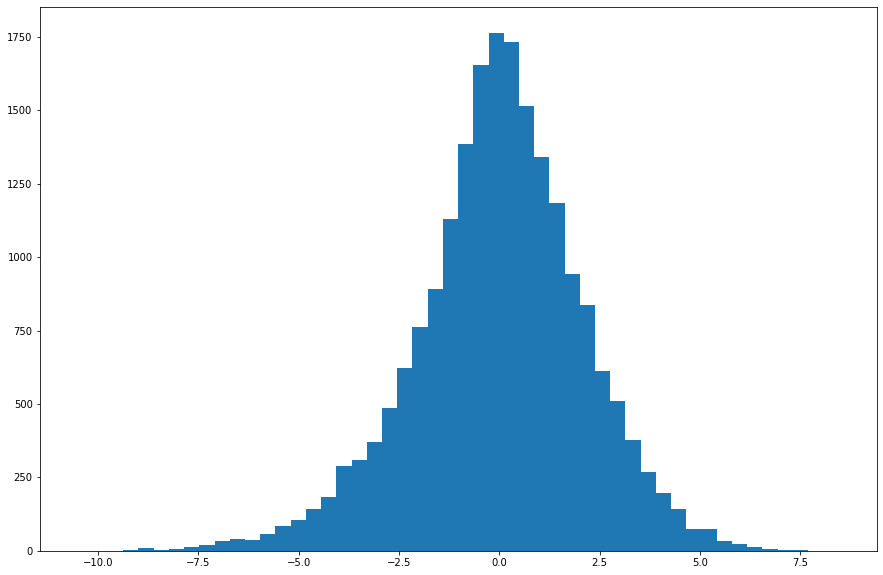

In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import gcf
fig = gcf()

fig.set_size_inches(15, 10, forward=True)

plt.hist(y_test - preds, bins = 50)

# Решаем задачу с текстовыми описаниями

## Подготовка данных

In [0]:
# в начале лекции мы создали tfidf матрицу всех наших текстов
X_np.shape

(50000, 21545)

### Кластеризация

In [0]:
# вернем нашу изначальный датасет и перекодируем
df = pd.read_csv('/content/Sberbank_materials/winemag-data-130k-v2.csv', index_col='Unnamed: 0')
df.drop(columns=['region_2', 'taster_name', 'taster_twitter_handle', 'designation'], inplace=True)
df.dropna(inplace=True)

Строим классы по аналогии с тем, как делали до этого

In [0]:
def make_class(point):
    if point < 87:
        return 1
    elif point >= 87 and point < 90:
        return 2
    elif point >= 90:
        return 3

df['points'] = df['points'].apply(make_class)
df.head(10)

,country,description,points,price,province,region_1,title,variety,winery
2,us,tart and snappy the flavors of lime flesh and ...,2,14.0,oregon,willamette valley,rainstorm 2013 pinot gris willamette valley,pinot gris,rainstorm
3,us,pineapple rind lemon pith and orange blossom s...,2,13.0,michigan,lake michigan shore,st julian 2013 reserve late harvest riesling l...,riesling,st julian
4,us,much like the regular bottling from 2012 this ...,2,65.0,oregon,willamette valley,sweet cheeks 2012 vintner s reserve wild child...,pinot noir,sweet cheeks
5,spain,blackberry and raspberry aromas show a typical...,2,15.0,northern spain,navarra,tandem 2011 ars in vitro tempranillo merlot na...,tempranillo merlot,tandem
6,italy,here s a bright informal red that opens with a...,2,16.0,sicily sardinia,vittoria,terre di giurfo 2013 belsito frappato vittoria,frappato,terre di giurfo
7,france,this dry and restrained wine offers spice in p...,2,24.0,alsace,alsace,trimbach 2012 gewurztraminer alsace,gewürztraminer,trimbach
9,france,this has great depth of flavor with its fresh ...,2,27.0,alsace,alsace,jean baptiste adam 2012 les natures pinot gris...,pinot gris,jean baptiste adam
10,us,soft supple plum envelopes an oaky structure i...,2,19.0,california,napa valley,kirkland signature 2011 mountain cuvée caberne...,cabernet sauvignon,kirkland signature
11,france,this is a dry wine very spicy with a tight tau...,2,30.0,alsace,alsace,leon beyer 2012 gewurztraminer alsace,gewürztraminer,leon beyer
12,us,slightly reduced this wine offers a chalky tan...,2,34.0,california,alexander valley,louis m martini 2012 cabernet sauvignon alexan...,cabernet sauvignon,louis m martini


In [0]:
df['points'].value_counts()

3    19433
2    17381
1    13186
Name: points, dtype: int64

In [0]:
# Подключаем класс для предобработки данных
from sklearn import preprocessing

# Напишем функцию, которая принимает на вход DataFrame, кодирует числовыми значениями категориальные признаки
# и возвращает обновленный DataFrame и сами кодировщики.
def number_encode_features(init_df):
    result = init_df.copy() # копируем нашу исходную таблицу
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object: # np.object -- строковый тип / если тип столбца - строка, то нужно его закодировать
            encoders[column] = preprocessing.LabelEncoder() # для колонки column создаем кодировщик
            result[column] = encoders[column].fit_transform(result[column]) # применяем кодировщик к столбцу и перезаписываем столбец
    return result, encoders

# используем все, кроме описания
encoded_data, encoders = number_encode_features(df.drop(columns='description')) # Теперь encoded data содержит закодированные кат. признаки 
encoded_data.head()

,country,points,price,province,region_1,title,variety,winery
2,6,2,14.0,41,1070,36190,269,8539
3,6,2,13.0,28,481,40588,296,9454
4,6,2,65.0,41,1070,41319,273,9602
5,5,2,15.0,37,660,41660,370,9651
6,4,2,16.0,48,1057,42534,105,9865


In [0]:
# выделим целевую переменную - качество
y = np.array(encoded_data['points'])

In [0]:
encoded_data.drop(columns=['price', 'points'], inplace=True)

In [0]:
encoded_data.head()

,country,province,region_1,title,variety,winery
2,6,41,1070,36190,269,8539
3,6,28,481,40588,296,9454
4,6,41,1070,41319,273,9602
5,5,37,660,41660,370,9651
6,4,48,1057,42534,105,9865


In [0]:
X_np.shape

(50000, 21545)

In [0]:
# нормализуем наши данные
from sklearn.preprocessing import scale
# скейлим (первой формулой выше) 
# тут получаем результаты на НЕ one hot кодировании, как делали на 6 занятии (другой тип перекодировки категор. признаков)
X_scaled = scale(encoded_data, with_std=True, with_mean=True)
X_scaled[0]

array([0.78577632, 0.71326362, 1.57681052, 0.89475765, 0.43482968,
       0.89242649])

In [0]:
X_scaled.shape

(50000, 6)

In [0]:
X = np.append(X_scaled, X_np.toarray(), axis=1)
X.shape

(50000, 21551)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Random forest

In [0]:
from sklearn.model_selection import GridSearchCV
# перебираем глубину
# перебираем мин кол-во для разделения
# максимально кол-во признаков для более случайной выборки
param_grid = {'max_depth': [i for i in range(2, 15)],
              'min_samples_split': [i for i in range(2, 10)],
              'max_features': [2, len(X_scaled[0])-1]
              }

# инициализируем случайный лес с перебором по кросс-вал на выбранных выше праметрах
gs = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
gs.fit(X_train[:10000], y_train[:10000])

# best_params_ содержит в себе лучшие подобранные параметры, best_score_ лучшее качество
print()
gs.best_params_, gs.best_score_

KeyboardInterrupt: ignored

In [0]:
from sklearn.ensemble import RandomForestClassifier
# инициализируем и проверим на лучших параметрах
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
from sklearn import metrics

preds = forest.predict(X_test)

print(metrics.classification_report(y_test, preds,
                              target_names=['плохое вино',
                                            'среднее вино',
                                            'хорошее вино']))

              precision    recall  f1-score   support

 плохое вино       0.60      0.63      0.61      2576
среднее вино       0.52      0.47      0.49      3506
хорошее вино       0.69      0.72      0.70      3918

    accuracy                           0.61     10000
   macro avg       0.60      0.61      0.60     10000
weighted avg       0.61      0.61      0.61     10000



In [0]:
def plot_feature_importances(model, columns):
    # выбираем кол-во признаков для отображения
    nr_f = 10
    # берем данные для графика
    # берем алгоритм с лучшими параметрами
    # по х мы берем важность признаков исходя из критерия Джини, сортируем их вместе с названиями колонок по возрастанию
    imp = pd.Series(data = model.feature_importances_, 
                    index=columns).sort_values(ascending=False)
    # построили фигуру
    plt.figure(figsize=(7,5))
    # отобразили название
    plt.title("Важность признаков | Feature importance")
    # построили 10 самых важных признаков
    ax = sns.barplot(y=imp.index[:nr_f], x=imp.values[:nr_f], orient='h')

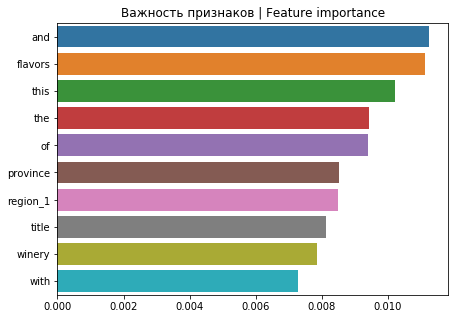

In [0]:
# вызвали функцию отображения самых важных признаков
plot_feature_importances(forest, list(encoded_data.columns) + vectorizer.get_feature_names())

## LSTM

In [0]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNLSTM
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [0]:
df = pd.read_csv('/content/Sberbank_materials/winemag-data-130k-v2.csv', index_col='Unnamed: 0')
def make_class(point):
    if point < 87:
        return 1
    elif point >= 87 and point < 90:
        return 2
    elif point >= 90:
        return 3

df['points'] = df['points'].apply(make_class)
df.head(7)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,2,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,2,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,2,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,2,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,2,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,2,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,2,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo


In [0]:
y = pd.get_dummies(df['points'])
y.head()

,1,2,3
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [0]:
y = np.array(y.values, int)

In [0]:
y

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [0]:
import string

def preprocess(doc):
    # к нижнему регистру
    doc = doc.lower()
    # убираем пунктуацию, пробелы, прочее
    for p in string.punctuation + string.whitespace:
        doc = doc.replace(p, ' ')
    # убираем лишние пробелы, объединяем обратно
    doc = doc.strip()
    doc = ' '.join([w for w in doc.split(' ') if w != ''])
    return doc

In [0]:
df['description'] = df['description'].map(preprocess)

In [0]:
df['description'].head()

0    aromas include tropical fruit broom brimstone ...
1    this is ripe and fruity a wine that is smooth ...
2    tart and snappy the flavors of lime flesh and ...
3    pineapple rind lemon pith and orange blossom s...
4    much like the regular bottling from 2012 this ...
Name: description, dtype: object

In [0]:
list_sentences_train = df['description']

In [0]:
# токенизируем слова
max_features = 50000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)

In [0]:
list_tokenized_train[:1]

[[17,
  863,
  201,
  14,
  1969,
  3577,
  1,
  89,
  106,
  2,
  18,
  897,
  196,
  1016,
  918,
  306,
  14382,
  48,
  62,
  1,
  89,
  417,
  140,
  358,
  19]]

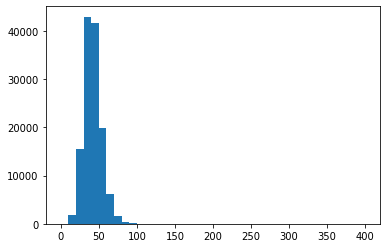

In [0]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()

In [0]:
maxlen = 100
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.2)

In [0]:
X_train.shape, y_train.shape

((103976, 100), (103976, 3))

In [0]:
X_test.shape, y_test.shape

((25995, 100), (25995, 3))

In [0]:
embed_size = 248

inp = Input(shape=(maxlen, ))
x = Embedding(max_features, embed_size)(inp)
x = CuDNNLSTM(248, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)

In [0]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
batch_size = 32
epochs = 5

model.fit(X_t,
          y,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)




Train on 116973 samples, validate on 12998 samples
Epoch 1/5





116973/116973 [==============================] - 62s 527us/step - loss: 0.4168 - acc: 0.7935 - val_loss: 0.3675 - val_acc: 0.8229
Epoch 2/5
116973/116973 [==============================] - 53s 457us/step - loss: 0.3527 - acc: 0.8340 - val_loss: 0.3543 - val_acc: 0.8275
Epoch 3/5
116973/116973 [==============================] - 53s 455us/step - loss: 0.3071 - acc: 0.8620 - val_loss: 0.3642 - val_acc: 0.8274
Epoch 4/5
116973/116973 [==============================] - 53s 455us/step - loss: 0.2590 - acc: 0.8872 - val_loss: 0.3867 - val_acc: 0.8294
Epoch 5/5
116973/116973 [==============================] - 53s 455us/step - loss: 0.2136 - acc: 0.9083 - val_loss: 0.4322 - val_acc: 0.8223


In [0]:
df.loc[123, 'description']

'the blend is roughly two thirds shiraz and one third cabernet and the result combines berries with cassis and generosity with structure all framed by toasty oak savory in character long and dusty on the finish drink now 2018'

In [0]:
df.loc[123, ['price', 'points']]

price     40
points     3
Name: 123, dtype: object

[0.00470201 0.24969885 0.7396253 ]


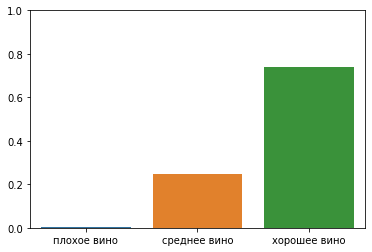

In [0]:
import seaborn as sns
# фраза, которую хотим распознать
test_phrase = df.loc[123, 'description']
# токенизированная слова, которых не будет заменятся на 1
tokenized_phraze = tokenizer.texts_to_sequences([test_phrase])

# обрезка под нужный формат (у нас 250 слов) - не хватает - заолняем нулями
# слишкоим много - обрезаем
padded_tokenized = pad_sequences(tokenized_phraze, maxlen=maxlen)

# фиксируем ось y, по которой происходит предсказание (0..1)
plt.ylim(0., 1.)
# строим по y предсказания от сети (следите за форматом ввода)
# по х - названия распознаваемых классов
print(model.predict(np.array(padded_tokenized) )[0])
ax = sns.barplot(x=['плохое вино', 'среднее вино', 'хорошее вино'], y=model.predict(np.array(padded_tokenized) )[0])

In [0]:
preds = model.predict(X_test)

In [0]:
preds[:5]

array([[2.6862025e-03, 1.2507141e-01, 8.5667503e-01],
       [5.4836273e-05, 4.1996837e-03, 9.9531460e-01],
       [3.3103281e-01, 6.5231353e-01, 2.3256898e-02],
       [5.2772421e-01, 4.6591210e-01, 6.7776620e-02],
       [4.9257353e-01, 4.8981416e-01, 2.4349093e-02]], dtype=float32)

In [0]:
np.argmax(preds, axis = 1)

array([2, 2, 1, ..., 1, 1, 2])

In [0]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(np.argmax(preds, axis = 1))

preds = lb.transform(np.argmax(preds, axis = 1))

In [0]:
preds

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [0]:
y_test

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [0]:
from sklearn import metrics

print(metrics.classification_report(y_test, preds,
                              target_names=['плохое вино',
                                            'среднее вино',
                                            'хорошее вино']))

              precision    recall  f1-score   support

 плохое вино       0.94      0.83      0.88      6947
среднее вино       0.79      0.92      0.85      9219
хорошее вино       0.96      0.89      0.93      9829

   micro avg       0.89      0.89      0.89     25995
   macro avg       0.90      0.88      0.89     25995
weighted avg       0.90      0.89      0.89     25995
 samples avg       0.89      0.89      0.89     25995

